Blatt 6 - Praktische Aufgabe 2

In [158]:
import numpy as np
import matplotlib.pyplot as plt


a) Die Berechnung ist relativ simpel, allerdings etwas nervig mit den Indizes (ich schreibe das hier nebenbei um 6 Uhr morgens). Folgende Formel wird berechnet:

$$h_i a_2^{(i-1)} + 2(h_i + h_{i+1})a_2^{(i)} + h_{i+1}a_2^{(i+1)}$$

Die Matrix $A$ hat die Dimension $n-1$ also in diesem Falle $3-1 = 2$. Man muss den Vektor $b$ auch etwas zurechtschneiden, als auch $A$, aufgrund der Randbedingungen (und linalg.solve() mag singuläre Matrizen überhaupt nicht).


In [159]:
def compute_rhs(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    n = len(x) - 1
    b = np.zeros(n-1)
    hy = np.diff(y)
    h = np.diff(x)

    for i in range(0, n-1):
        b[i] = 3*(hy[i+1]/h[i+1] - hy[i]/h[i])

    return b


def compute_matrix(x: np.ndarray) -> np.ndarray:
    n = len(x) - 1
    h = np.diff(x)
    A = np.zeros([n-1, n-1])

    # Die komischen if-Bedingungen kommen von den Randbedingungen
    for i in range(0, n-1):
        if i >= 0:
            A[i][i-1] = h[i]

        A[i][i] = 2*(h[i+1]+h[i])

        if i < n-2:
            A[i][i+1] = h[i+1]

    return A


x=np.array([0,1,2,3])
y=np.array([0,1,0,1])
A=compute_matrix(x)
b=compute_rhs(x,y)

print(A)
print(b)

[[4. 1.]
 [1. 4.]]
[-6.  6.]


b) Jetzt müssen die restlichen Gleichungen berechnet werden.
$a_2^{(i)}$ haben wir ja bereits in der letzten Aufgabe berechnet mit den $n-1$ linearen Gleichungen (und den 2 Randbedingungen).
Die $a_0^{(i)}$ ist relativ simpel mit $$a_0^{(i)} = y_i i = 1,\dots,n$$ auszurechnen.
Die $a_3^{(i)}$ berechnen wir folgendermaßen:
$$a_3^{(i)} = \frac{a_2^{(i-1)} - a_2^{(i)}}{3h_i}$$
Auf eine ähnliche Weise berechnen wir die $a_1^{(i)}:$
$$\frac{y_{i-1}-y_{i}-a_2^{(i)}h_i^2-a_3^{(i)}h_i^3}{-h_i}$$
Das gesamte Gleichungssystem lässt sich mit linalg.solve() schnell berechnen und liefert uns alle Koeffizienten.

In [160]:
def compute_coeff(x: np.ndarray, y: np.ndarray) -> tuple:
    n = len(x)
    h = np.diff(x)

    # Dimensionierung nach Hinweis
    a0 = np.zeros(n)
    a1 = np.zeros(n)
    a2 = np.zeros(n)
    a3 = np.zeros(n)

    # Matrizen und Vektoren für die Koeffizienten a1-a3
    A1 = np.zeros([n-1, n-1])
    b1 = np.zeros(n-1)
    A2 = compute_matrix(x)
    b2 = compute_rhs(x, y)
    A3 = np.zeros([n-1, n-1])
    b3 = np.zeros(n-1)

    # Berechnung von a2(1) und a2(2) aus a)
    a2[1:-1] = np.linalg.solve(A2, b2)

    # Formel für die Berechnung der a0(i)
    for i in range(1,n):
        a0[i] = y[i]

    # Ausrechnen von a3 durch lineares Gleichungssystem mit Diagonalmatrix
    for i in range(1,n):
        A3[i-1][i-1] = 1
        b3[i-1] = (-a2[i-1]+a2[i])/3*h[i-1]

    a3[1:] = np.linalg.solve(A3, b3)

    # Ausrechnen von a1 durch lineares Gleichungssystem mit Diagonalmatrix
    for i in range(1,n):
        A1[i-1][i-1] = 1
        b1[i-1] = (y[i-1]-y[i]-a2[i]*h[i-2]**2+a3[i]*h[i-1]**3)/(-1*h[i-1])

    a1[1:] = np.linalg.solve(A1, b1)

    # Rückgabe als Tupel (ist angenehmer)
    return a0,a1,a2,a3



x=np.array([0,1,2,3])
y=np.array([0,1,0,1])
a0,a1,a2,a3 = compute_coeff(x, y)
print(a0)
print(a1)
print(a2)
print(a3)

[0. 1. 0. 1.]
[ 0.         -0.33333333 -0.33333333  1.66666667]
[ 0. -2.  2.  0.]
[ 0.         -0.66666667  1.33333333 -0.66666667]


c) Hier gibt es eigentlich nicht viel zu sagen. Da $z$ in einem geschlossenen Intervall liegt, ist $ x_{i-1} \leq z \leq x_i$. Python lässt das Gott sei Dank leicht implementieren.

In [161]:
def find_interval(z: float, x: np.ndarray) -> int:
    n = len(x)

    for i in range(1,n):
        # Das ist hoffentlich selbsterklärend... ">=" btw "<=" weil geschlossenes Intervall
        if x[i-1] <= z <= x[i]:
            return i

test = np.array([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
x=np.array([0,1,2,3])
for i in range(0, len(test)):
    print(find_interval(test[i], x))

1
1
1
2
2
3
3


d) Die Splines werden ganz normal mit der Formel berechnet. Zuerst sucht die Funktion das Interval, in dem sich das $z$ befindet, durch die vorherige Funktion. Danach wird der Spline an diesem Punkt ausgewertet:
$$s_i(x) = a_0^{(i)}+a_1^{(i)}(x-x_i)+a_2^{(i)}(x-x_i)^2+a_3^{(i)}(x-x_i)^3$$

In [162]:
def evaluate_spline(z: float, x: np.ndarray, a0, a1, a2, a3) -> float:
    # "Finde Intervall und berechne Punkt im jeweiligen Spline
    i = find_interval(z, x)
    s = a0[i] + a1[i]*(z-x[i]) + a2[i]*(z-x[i])**2 + a3[i]*(z-x[i])**3

    return s

x=np.array([0,1,2,3])
y=np.array([0,1,0,1])
a0,a1,a2,a3 = compute_coeff(x, y)
test = np.array([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])

for i in range(0, len(test)):
    print(evaluate_spline(test[i], x, a0, a1, a2, a3))

1.1102230246251565e-16
0.7500000000000001
1.0
0.5
0.0
0.25000000000000006
1.0


e) Zu guter Letzt wird alles zusammengeklebt und für die Funktion $f(x) = \frac{1}{1+x^2}$ ausgewertet. Man erstelle 10 äquidistante Stützstellen mit linspace() und suche dann die dazugehörigen $y_i$. Danach muss man nochmal mit linspace() ein dichtes Gitter erstellen und auswerten. Zusätzlich habe ich neben $n = 10$ auch noch $n = 100$ betrachtet, um zu sehen, ob die Genauigkeit tatsächlich zunimmt. Sie nimmt tatsächlich sehr schnell zu, sodass bereits bei 100 Stützstellen kaum ein Fehler zu sehen ist.

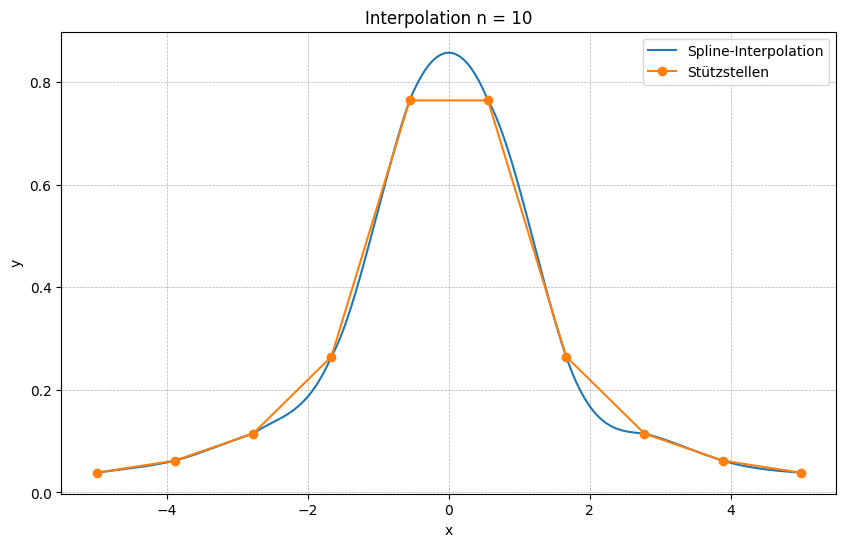

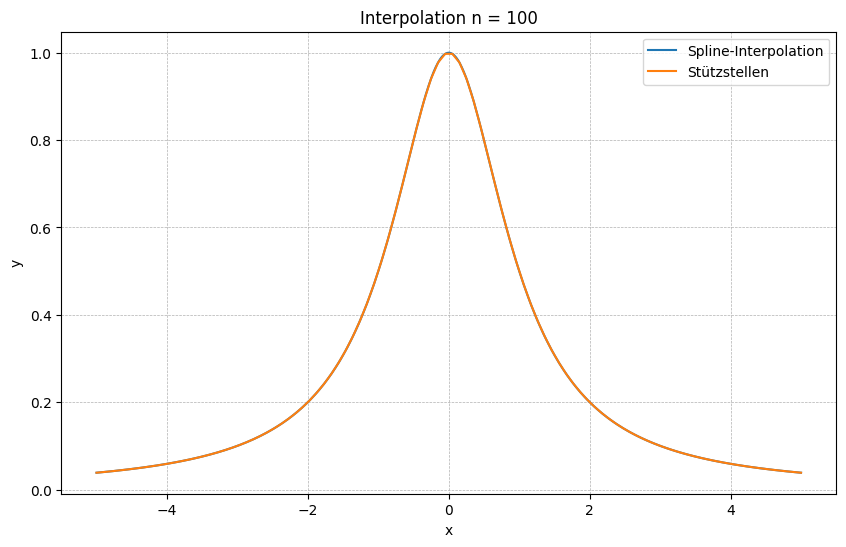

In [163]:
# Zu interpolierende Funktion
def f(x: np.array) -> np.array:
    return 1/(1+x**2)

# Stützstellen berechnen
x = np.linspace(-5, 5, 10)
y = f(x)

# Gitter zum Ausrechnen
z = np.linspace(-5,5,1000)
result = np.ndarray(1000)

# Koeffizienten berechnen
a0, a1, a2, a3 = compute_coeff(x, y)

# Splines ausrechnen
for i in range(0,len(z)):
    result[i] = evaluate_spline(z[i], x, a0, a1, a2, a3)

#Plotting n = 10 ----------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(z, result, label="Spline-Interpolation")
plt.plot(x, y, label="Stützstellen", marker='o')

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Interpolation n = 10")

plt.show()


# Stützstellen berechnen
x = np.linspace(-5, 5, 100)
y = f(x)

# Gitter zum Ausrechnen
z = np.linspace(-5,5,1000)
result = np.ndarray(1000)

# Koeffizienten berechnen
a0, a1, a2, a3 = compute_coeff(x, y)

# Splines ausrechnen
for i in range(0,len(z)):
    result[i] = evaluate_spline(z[i], x, a0, a1, a2, a3)

#Plotting n = 100 ----------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(z, result, label="Spline-Interpolation")
plt.plot(x, y, label="Stützstellen")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Interpolation n = 100")

plt.show()